In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = r"steam_reviews_clean.parquet"

con = duckdb.connect()

In [5]:
df_head = con.execute("""
    SELECT *
    FROM parquet_scan(?)
    LIMIT 5
""", [df]).df()

df_head

,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,timestamp_created,...,voted_up,steam_purchase,received_for_free,written_during_early_access,votes_up,votes_funny,weighted_vote_score,comment_count,language,is_edited
0,148912575,10,Counter-Strike,76561198363716821,0,2,197,41,197,2023-10-26 07:10:19-07:00,...,True,True,False,False,0,0,0.00000,0,english,False
1,148895540,10,Counter-Strike,76561198134752176,69,1,12107,0,12107,2023-10-26 00:41:36-07:00,...,True,False,False,False,0,0,0.00000,0,english,False
2,148895230,10,Counter-Strike,76561197985437504,0,5,42519,3,42515,2023-10-26 00:32:49-07:00,...,True,False,False,False,0,0,0.00000,0,english,False
3,148865538,10,Counter-Strike,76561199015747395,71,34,30,0,30,2023-10-25 11:11:55-07:00,...,True,True,False,False,0,0,0.00000,0,english,False
4,148862089,10,Counter-Strike,76561199479067349,5,6,209,200,209,2023-10-25 10:03:14-07:00,...,True,True,False,False,1,0,0.52381,0,english,False


In [8]:
df_game_month = con.execute("""
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        COUNT(*) AS review_count,
        AVG(CAST(voted_up as INT)) AS pos_rate,
        AVG(author_playtime_forever) / 60 AS avg_playtime_hours,
        AVG(author_num_reviews) AS avg_num_reviews,
        AVG(CAST(is_edited as INT)) AS edit_rate
    FROM parquet_scan(?)
    GROUP BY game, month
    ORDER BY game, month
""", [df]).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game,month,review_count,pos_rate,avg_playtime_hours,avg_num_reviews,edit_rate
0,Arcade Sundown,2023-10-01 00:00:00-07:00,26,1.0,5.741667,2.884615,0.115385
1,Armies of Riddle CLASSIC,2016-10-01 00:00:00-07:00,1,0.0,0.716667,17.000000,0.000000
2,Armies of Riddle CLASSIC,2017-01-01 00:00:00-08:00,1,0.0,0.166667,7.000000,0.000000
3,Build & Battle,2021-09-01 00:00:00-07:00,1,0.0,1.050000,87.000000,0.000000
4,Build & Battle,2021-10-01 00:00:00-07:00,2,1.0,2.675000,17.000000,0.000000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

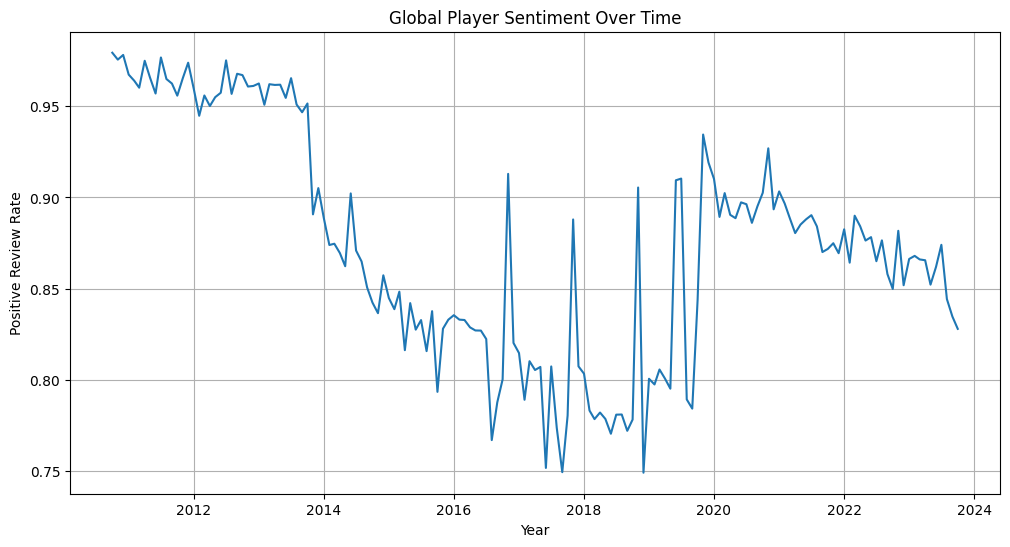

In [6]:
df_sentiment_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n_reviews
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [df]).df()

plt.figure(figsize=(12,6))
plt.plot(df_sentiment_time["month"], df_sentiment_time["positive_rate"])
plt.title("Global Player Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

In [11]:
top_games = con.execute("""
    SELECT 
        game, 
        COUNT(*) AS review_count,
        avg(CAST(voted_up AS INT)) AS pos_rate
    FROM parquet_scan(?)
    GROUP BY game
    ORDER BY review_count DESC
    LIMIT 5
""", [df]).df()

top_games

,game,review_count,pos_rate
0,Counter-Strike 2,2126686,0.885144
1,Terraria,606492,0.978120
2,Team Fortress 2,597758,0.941644
3,Tom Clancy's Rainbow Six Siege,551701,0.864590
4,Grand Theft Auto V,518834,0.815825


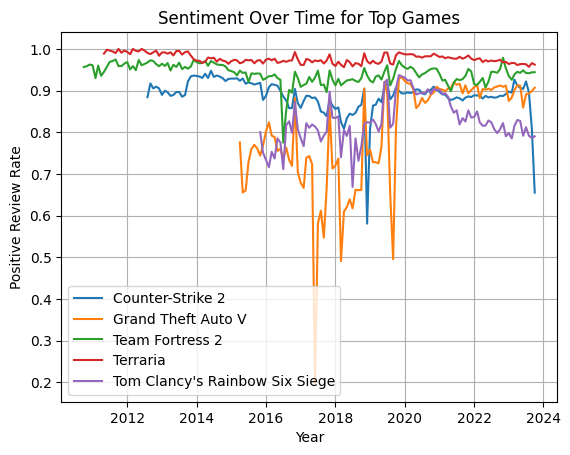

In [14]:
df_top_sentiment = con.execute("""
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        AVG(CAST(voted_up AS INT)) AS positive_rate
    FROM parquet_scan(?)
    WHERE game IN (
        SELECT game
        FROM parquet_scan(?)
        GROUP BY game
        ORDER BY COUNT(*) DESC
        LIMIT 5)
    GROUP BY game, month
    ORDER BY game, month
""", [df, df]).df()

for g in df_top_sentiment["game"].unique():
    subset = df_top_sentiment[df_top_sentiment["game"] == g]
    plt.plot(subset["month"], subset["positive_rate"], label = g)

plt.legend()
plt.title("Sentiment Over Time for Top Games")
plt.xlabel("Year")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

In [33]:
df_dips = con.execute("""
WITH monthly AS (
    SELECT 
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        AVG(CAST(voted_up AS INT)) AS positive_rate,
        COUNT(*) AS n_reviews
    FROM parquet_scan(?)
    GROUP BY game, month
),
lagged AS (
    SELECT *,
           LAG(positive_rate) OVER (PARTITION BY game ORDER BY month) AS prev_rate
    FROM monthly
)
SELECT *,
       (positive_rate - prev_rate) AS sentiment_change
FROM lagged
WHERE 
    prev_rate IS NOT NULL
    AND n_reviews >= 5000
    AND (positive_rate - prev_rate) <= -0.15
ORDER BY sentiment_change ASC
""", [df]).df()

con.register("dips", df_dips)

print(df_dips)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

                           game                     month  positive_rate  \
0      Total War: WARHAMMER III 2023-08-01 00:00:00-07:00       0.113063   
1                        VRChat 2022-07-01 00:00:00-07:00       0.187207   
2            Grand Theft Auto V 2017-06-01 00:00:00-07:00       0.193694   
3                      PAYDAY 2 2015-10-01 00:00:00-07:00       0.307353   
4                   War Thunder 2023-05-01 00:00:00-07:00       0.320876   
5   The Elder Scrolls V: Skyrim 2015-04-01 00:00:00-07:00       0.517049   
6         ARK: Survival Evolved 2016-09-01 00:00:00-07:00       0.383843   
7              Counter-Strike 2 2018-12-01 00:00:00-08:00       0.580752   
8                     New World 2021-11-01 00:00:00-07:00       0.534392   
9       Wolcen: Lords of Mayhem 2020-02-01 00:00:00-08:00       0.555234   
10                Rocket League 2020-09-01 00:00:00-07:00       0.644530   
11                 DOOM Eternal 2020-05-01 00:00:00-07:00       0.691162   
12   Warhamm

In [45]:
playtime_analysis = con.execute("""
WITH review_data AS (
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        voted_up,
        author_playtime_at_review  / 60.0 AS playtime_hours_at_review,
        author_playtime_forever  / 60.0 AS playtime_hours
    FROM parquet_scan(?)
    WHERE author_playtime_forever IS NOT NULL AND author_playtime_at_review IS NOT NULL
),

labeled AS (
    SELECT 
        r.*,
        CASE 
            WHEN (r.game, r.month) IN (SELECT game, month FROM dips)
            THEN 'Dip Period'
            ELSE 'Normal Period'
        END AS period_type
    FROM review_data r
)

SELECT 
    period_type,
    voted_up,
    COUNT(*) AS n_reviews,
    AVG(playtime_hours_at_review) AS avg_playtime_at_review,
    MEDIAN(playtime_hours_at_review) AS median_playtime_at_review,
    AVG(playtime_hours) AS avg_playtime,
    MEDIAN(playtime_hours) AS median_playtime
FROM labeled
GROUP BY period_type, voted_up
ORDER BY period_type, voted_up
""", [df]).df()

print(playtime_analysis)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

     period_type  voted_up  n_reviews  avg_playtime_at_review  \
0     Dip Period     False     165576              319.089961   
1     Dip Period      True     172155              213.047103   
2  Normal Period     False    6527769              123.786330   
3  Normal Period      True   43128536              116.787123   

   median_playtime_at_review  avg_playtime  median_playtime  
0                  87.266667    483.566038       146.750000  
1                  50.700000    484.515516       154.083333  
2                   7.616667    206.746657        13.333333  
3                  17.450000    256.040579        43.566667  


In [52]:
df_engagement = con.execute("""
WITH review_data AS (
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        voted_up,
        author_playtime_at_review / 60.0 AS playtime_hours
    FROM parquet_scan(?)
    WHERE author_playtime_at_review IS NOT NULL AND author_playtime_at_review > 0
),

labeled AS (
    SELECT 
        r.*,
        CASE 
            WHEN (r.game, r.month) IN (SELECT game, month FROM dips)
            THEN 'Dip Period'
            ELSE 'Normal Period'
        END AS period_type
    FROM review_data r
),

sampled AS (
    SELECT *
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (
                   PARTITION BY period_type, voted_up
                   ORDER BY RANDOM()
               ) AS rn
        FROM labeled
    )
    WHERE rn <= 50000
)

SELECT 
    period_type,
    voted_up,
    playtime_hours
FROM sampled
""", [df]).df()

df_engagement["log_playtime"] = np.log1p(df_engagement["playtime_hours"])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_engagement["period_type"] = df_engagement["period_type"].astype("category")
df_engagement["voted_up"] = df_engagement["voted_up"].astype("category")


model = smf.ols(
    "log_playtime ~ C(period_type) + C(voted_up) + C(period_type):C(voted_up)",
    data=df_engagement
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                   sum_sq        df             F  \
C(period_type)               90571.769585       1.0  29085.528777   
C(voted_up)                    905.574039       1.0    290.809155   
C(period_type):C(voted_up)    9645.466989       1.0   3097.471861   
Residual                    622783.645044  199996.0           NaN   

                                  PR(>F)  
C(period_type)              0.000000e+00  
C(voted_up)                 3.684948e-65  
C(period_type):C(voted_up)  0.000000e+00  
Residual                             NaN  


In [54]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df_engagement["group"] = (
    df_engagement["period_type"].astype(str)
    + "_"
    + df_engagement["voted_up"].astype(str)
)


tukey = pairwise_tukeyhsd(
    endog=df_engagement["log_playtime"],
    groups=df_engagement["group"],
    alpha=0.05
)

print(tukey)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------
   Dip Period_False     Dip Period_True  -0.3046   0.0 -0.3333  -0.276   True
   Dip Period_False Normal Period_False  -1.7851   0.0 -1.8138 -1.7564   True
   Dip Period_False  Normal Period_True  -1.2113   0.0   -1.24 -1.1826   True
    Dip Period_True Normal Period_False  -1.4805   0.0 -1.5091 -1.4518   True
    Dip Period_True  Normal Period_True  -0.9067   0.0 -0.9354  -0.878   True
Normal Period_False  Normal Period_True   0.5738   0.0  0.5451  0.6025   True
-----------------------------------------------------------------------------


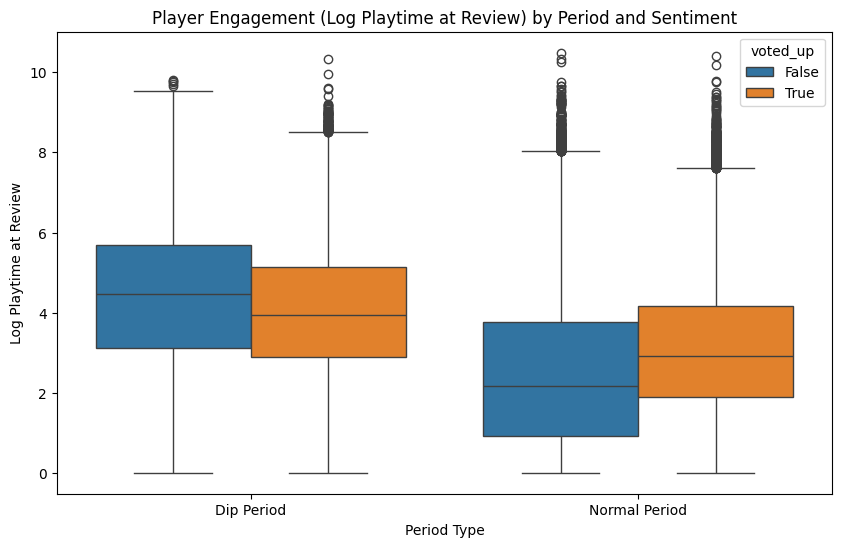

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_engagement,
    x="period_type",
    y="log_playtime",
    hue="voted_up"
)

plt.title("Player Engagement (Log Playtime at Review) by Period and Sentiment")
plt.xlabel("Period Type")
plt.ylabel("Log Playtime at Review")
plt.show()

In [41]:
edited_dips = con.execute("""
WITH review_data AS (
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        voted_up,
        (timestamp_updated > timestamp_created) AS is_edited
    FROM parquet_scan(?)
),
labeled AS (
    SELECT *,
        CASE 
            WHEN (game, month) IN (SELECT game, month FROM dips)
            THEN 'Dip Period'
            ELSE 'Normal Period'
        END AS period_type
    FROM review_data
)
SELECT 
    period_type,
    is_edited,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM labeled
GROUP BY period_type, is_edited
""", [df]).df()

print(edited_dips)

CatalogException: Catalog Error: Table with name labeled does not exist!
Did you mean "pg_tables"?

LINE 6: FROM labeled
             ^

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

C:\Users\rdlou\AppData\Local\Temp\ipykernel_43612\267580060.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


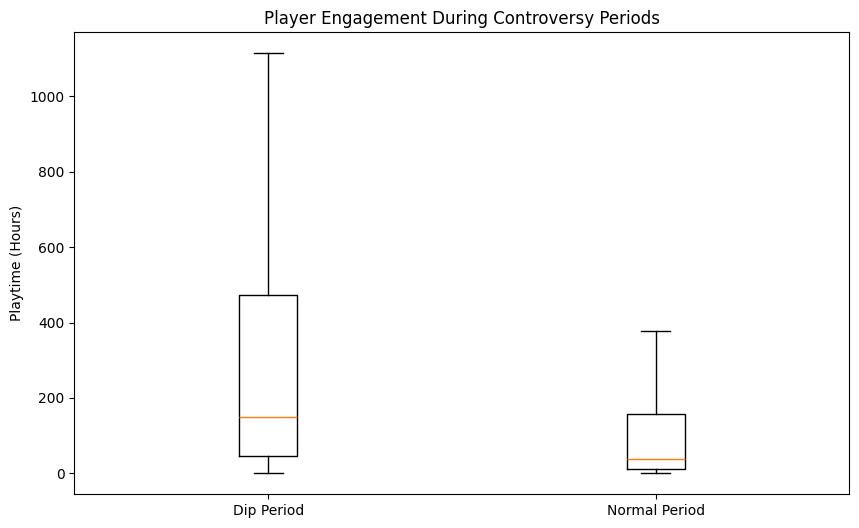

In [38]:
playtime_analysis = con.execute("""
WITH review_data AS (
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        voted_up,
        author_playtime_forever / 60.0 AS playtime_hours
    FROM parquet_scan(?)
    WHERE author_playtime_forever IS NOT NULL
),

labeled AS (
    SELECT 
        r.*,
        CASE 
            WHEN (r.game, r.month) IN (SELECT game, month FROM dips)
            THEN 'Dip Period'
            ELSE 'Normal Period'
        END AS period_type
    FROM review_data r
)

SELECT 
    period_type,
    voted_up,
    playtime_hours
FROM labeled
""", [df]).df()

plt.figure(figsize=(10,6))
plt.boxplot([
    playtime_analysis[playtime_analysis["period_type"] == 'Dip Period']["playtime_hours"],
    playtime_analysis[playtime_analysis["period_type"] == 'Normal Period']["playtime_hours"]
], labels=['Dip Period', 'Normal Period'], showfliers=False)

plt.ylabel("Playtime (Hours)")
plt.title("Player Engagement During Controversy Periods")
plt.show()

In [36]:
continued_playing = con.execute("""
SELECT
    voted_up,
    AVG(
        (EXTRACT(EPOCH FROM (author_last_played - timestamp_created)) / 3600)
    ) AS avg_hours_after_review
FROM parquet_scan(?)
WHERE author_last_played > timestamp_created
GROUP BY voted_up
""", [df]).df()

print(continued_playing)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   voted_up  avg_hours_after_review
0      True            16211.184493
1     False            14166.822129


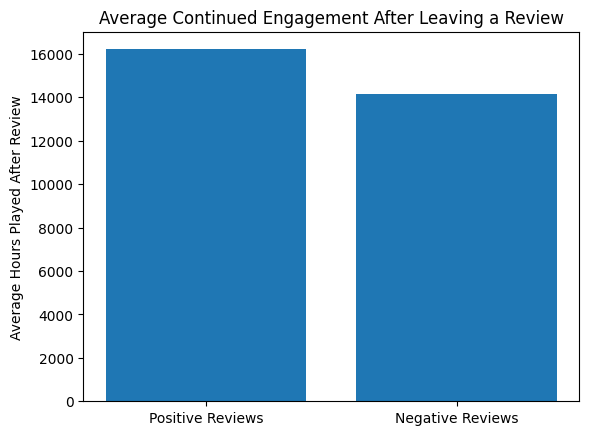

In [39]:
plt.bar(
    ["Positive Reviews", "Negative Reviews"],
    continued_playing["avg_hours_after_review"]
)

plt.title("Average Continued Engagement After Leaving a Review")
plt.ylabel("Average Hours Played After Review")
plt.show()

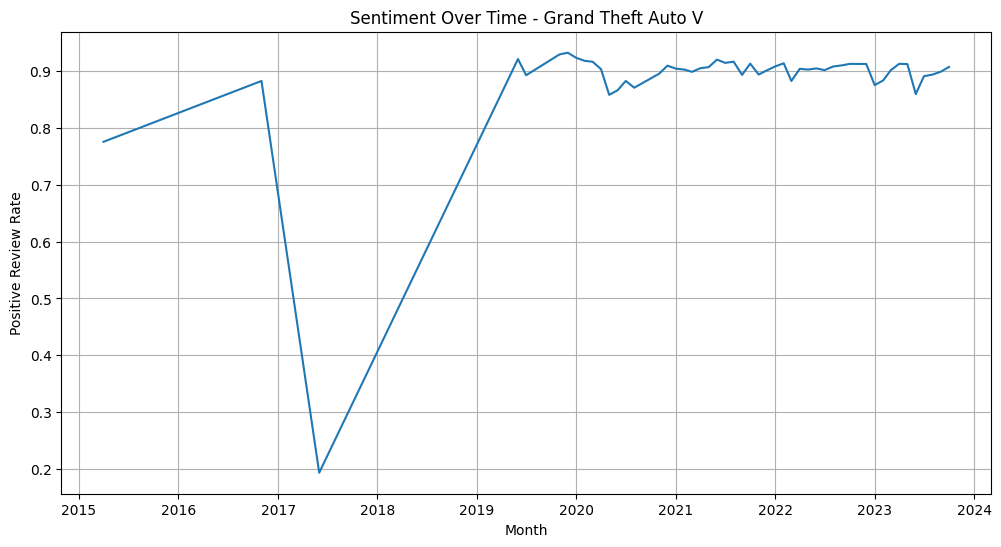

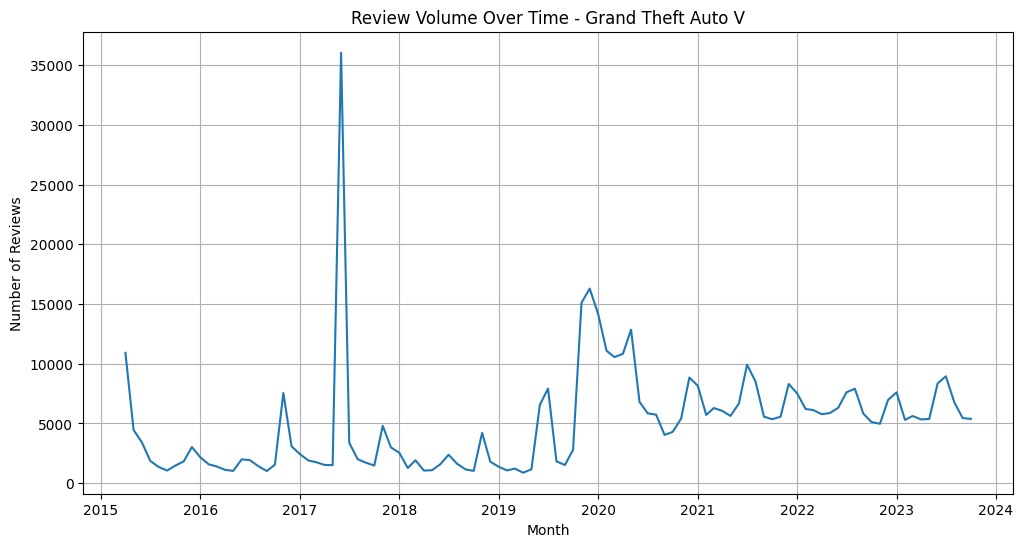

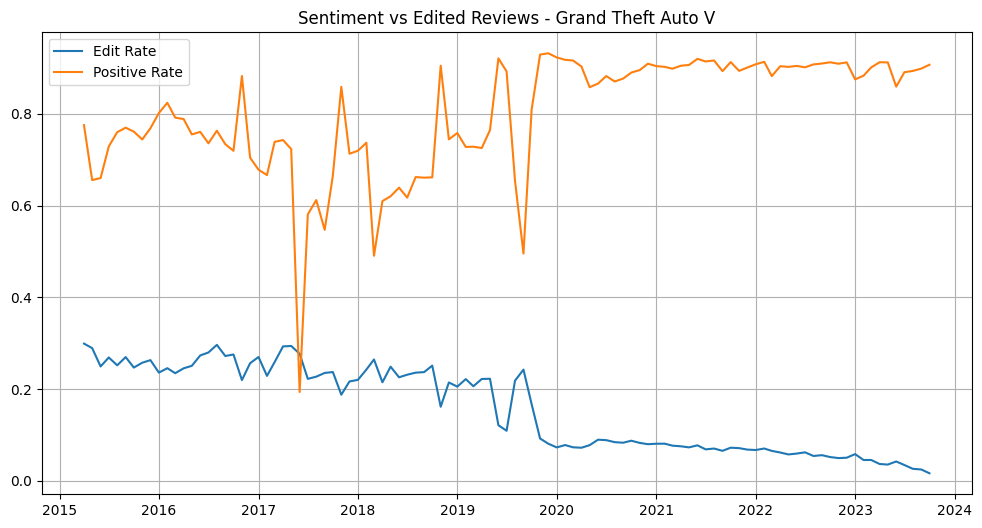

In [28]:
game_name = "Grand Theft Auto V"

df_sentiment = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n_reviews
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
HAVING COUNT(*) >= 5000
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_sentiment["month"], df_sentiment["positive_rate"])
plt.title(f"Sentiment Over Time - {game_name}")
plt.xlabel("Month")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

df_volume = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_volume["month"], df_volume["review_count"])
plt.title(f"Review Volume Over Time - {game_name}")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

df_edits = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(is_edited AS INT)) AS edit_rate,
    AVG(CAST(voted_up AS INT)) AS positive_rate
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_edits["month"], df_edits["edit_rate"], label="Edit Rate")
plt.plot(df_edits["month"], df_edits["positive_rate"], label="Positive Rate")
plt.title(f"Sentiment vs Edited Reviews - {game_name}")
plt.legend()
plt.grid(True)
plt.show()

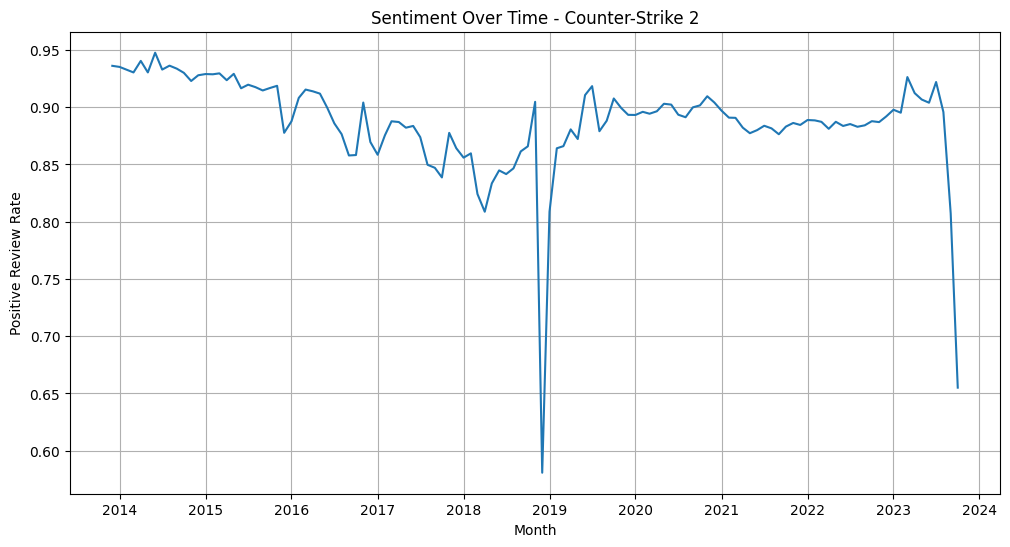

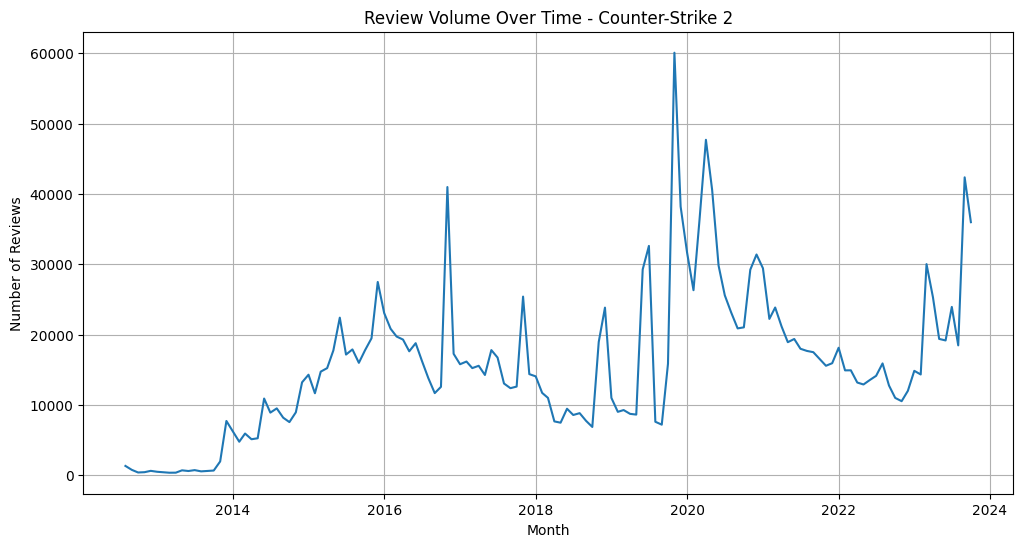

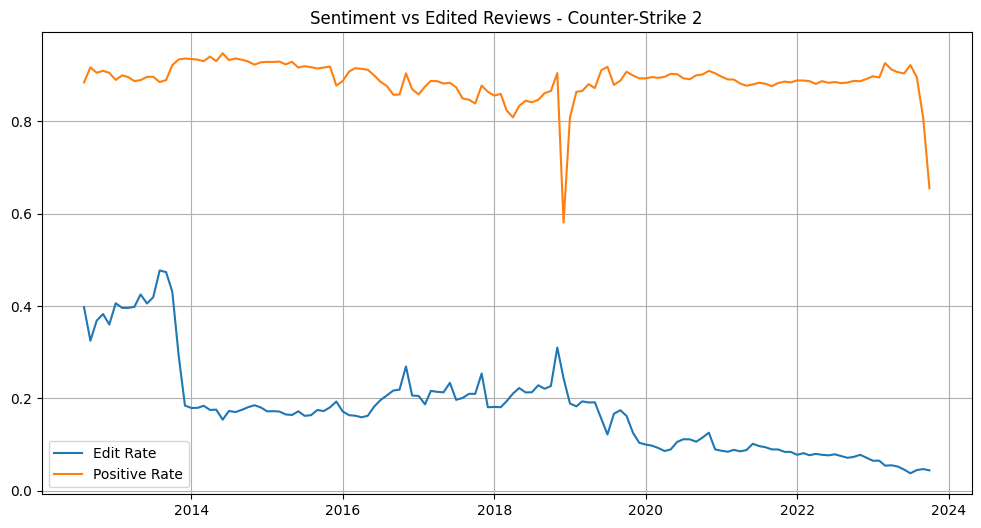

In [31]:
game_name = "Counter-Strike 2"

df_sentiment = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n_reviews
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
HAVING COUNT(*) >= 5000
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_sentiment["month"], df_sentiment["positive_rate"])
plt.title(f"Sentiment Over Time - {game_name}")
plt.xlabel("Month")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

df_volume = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_volume["month"], df_volume["review_count"])
plt.title(f"Review Volume Over Time - {game_name}")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

df_edits = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(is_edited AS INT)) AS edit_rate,
    AVG(CAST(voted_up AS INT)) AS positive_rate
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_edits["month"], df_edits["edit_rate"], label="Edit Rate")
plt.plot(df_edits["month"], df_edits["positive_rate"], label="Positive Rate")
plt.title(f"Sentiment vs Edited Reviews - {game_name}")
plt.legend()
plt.grid(True)
plt.show()

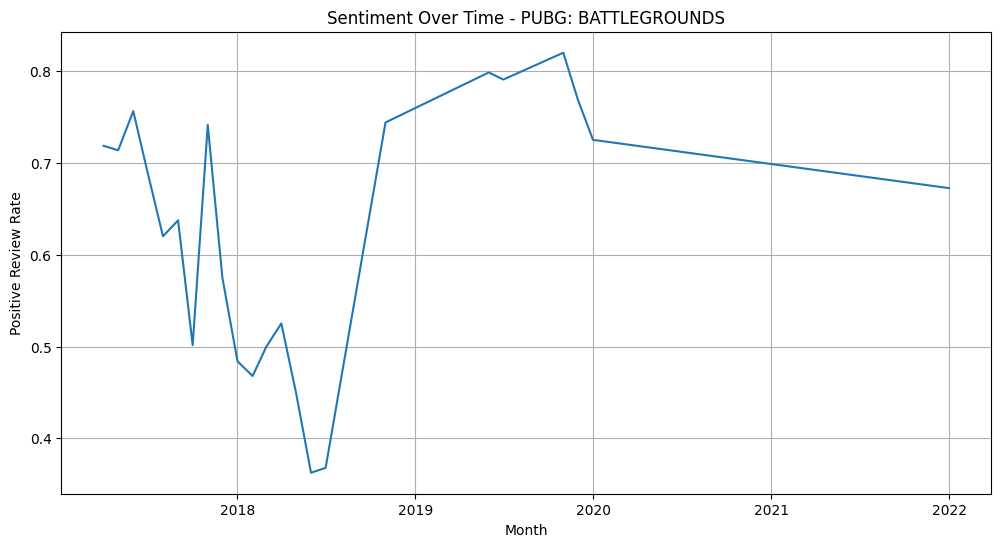

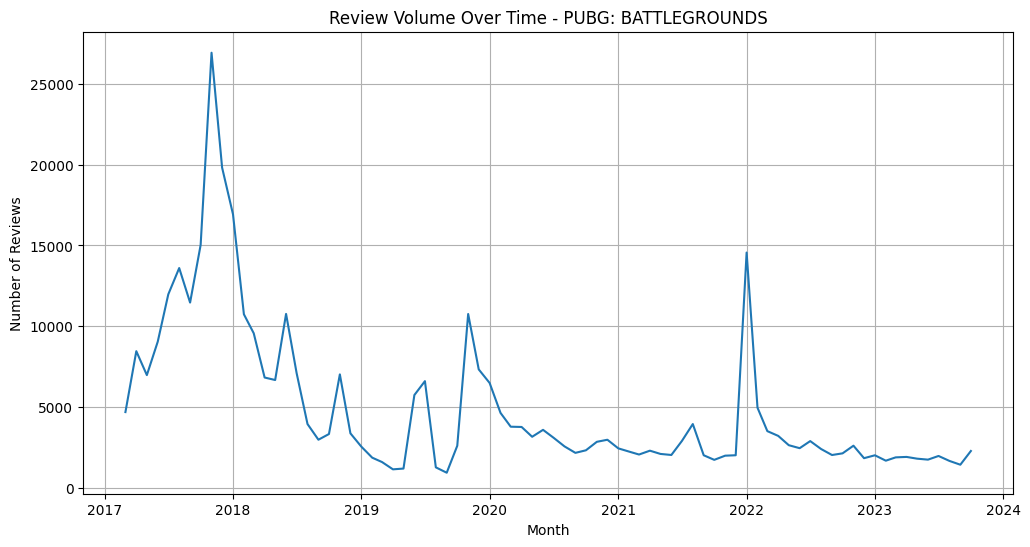

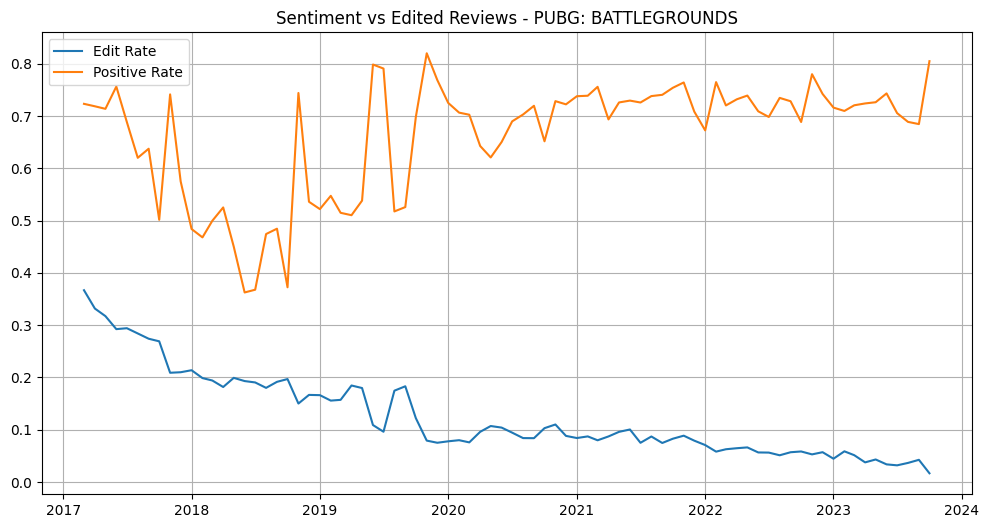

In [30]:
game_name = "PUBG: BATTLEGROUNDS"

df_sentiment = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n_reviews
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
HAVING COUNT(*) >= 5000
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_sentiment["month"], df_sentiment["positive_rate"])
plt.title(f"Sentiment Over Time - {game_name}")
plt.xlabel("Month")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

df_volume = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_volume["month"], df_volume["review_count"])
plt.title(f"Review Volume Over Time - {game_name}")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

df_edits = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(is_edited AS INT)) AS edit_rate,
    AVG(CAST(voted_up AS INT)) AS positive_rate
FROM parquet_scan(?)
WHERE game = ?
GROUP BY month
ORDER BY month
""", [df, game_name]).df()

plt.figure(figsize=(12,6))
plt.plot(df_edits["month"], df_edits["edit_rate"], label="Edit Rate")
plt.plot(df_edits["month"], df_edits["positive_rate"], label="Positive Rate")
plt.title(f"Sentiment vs Edited Reviews - {game_name}")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
df_shocks = con.execute("""
SELECT 
    game,
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY game, month
HAVING COUNT(*) > 500
ORDER BY game, month
""", [df]).df()

df_shocks

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game,month,positive_rate,n
0,*NEW* EPIC SCUFFED BHOP SIMULATOR 2023 (POG CH...,2020-12-01 00:00:00-08:00,0.960243,1484
1,*NEW* EPIC SCUFFED BHOP SIMULATOR 2023 (POG CH...,2021-01-01 00:00:00-08:00,0.914237,583
2,20 Minutes Till Dawn,2022-06-01 00:00:00-07:00,0.958138,3631
3,20 Minutes Till Dawn,2022-07-01 00:00:00-07:00,0.937652,1235
4,20 Minutes Till Dawn,2022-08-01 00:00:00-07:00,0.931611,658
...,...,...,...,...
15663,黑色沙漠(失效),2022-12-01 00:00:00-08:00,0.739623,530
15664,黑色沙漠(失效),2023-01-01 00:00:00-08:00,0.674905,526
15665,黑色沙漠(失效),2023-03-01 00:00:00-08:00,0.614897,631
15666,黑色沙漠(失效),2023-07-01 00:00:00-07:00,0.671202,882


In [18]:
edit_analysis = con.execute("""
SELECT
    is_edited,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    AVG(author_playtime_forever)/60 AS avg_hours,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY is_edited
""", [df]).df()

print(edit_analysis)

   is_edited  positive_rate   avg_hours         n
0      False       0.881096  227.275596  43812654
1       True       0.759952  420.323710   6181382


In [ ]:
playtime_sentiment = con.execute("""
SELECT
    CASE 
        WHEN author_playtime_forever/60 < 10 THEN 'Low'
        WHEN author_playtime_forever/60 < 100 THEN 'Medium'
        ELSE 'High'
    END AS playtime_group,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY playtime_group
""", [df]).df()